# Your first neural network - Keras version

Student: Angel Martinez-Tenor <br/>
Deep Learning Nanodegree Foundation - Udacity <br/>
May 2017 <br/>

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

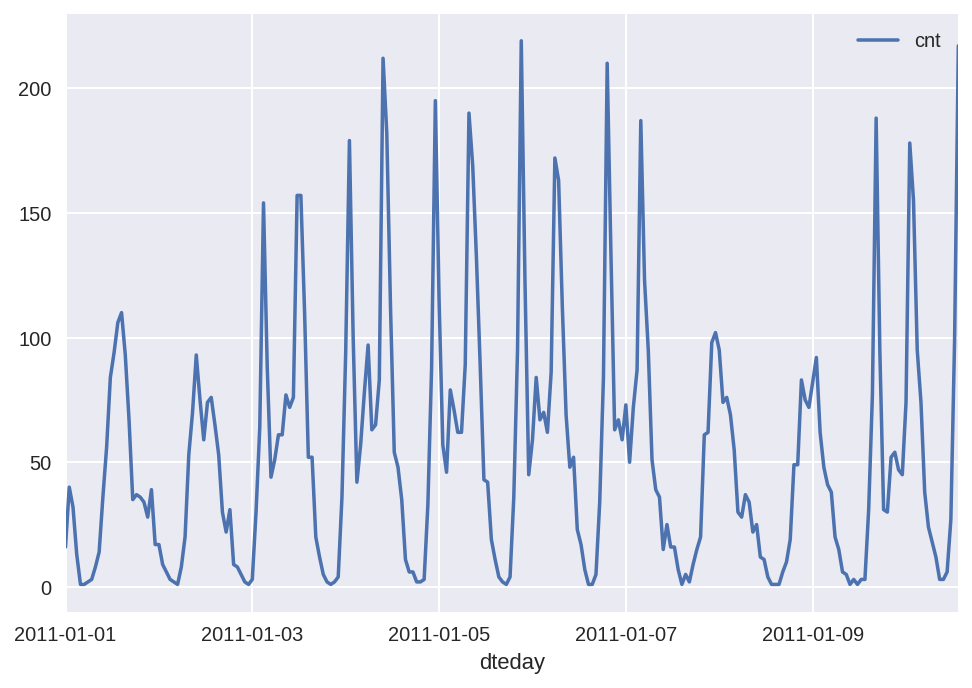

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')


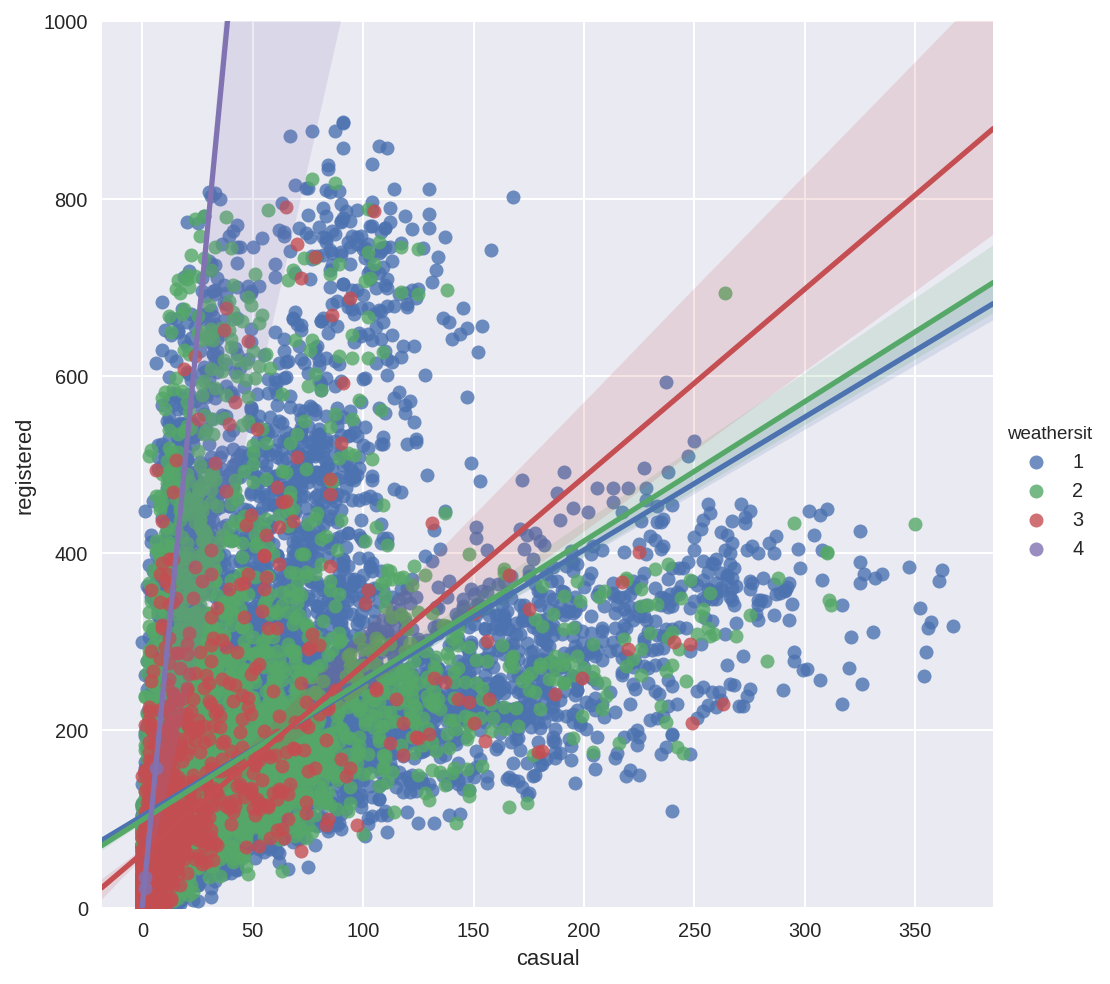

In [5]:
g = sns.PairGrid(rides, y_vars='registered', x_vars='casual', size=7, hue = 'weathersit')
plt.ylim(0, 1000)
g.map(sns.regplot).add_legend()


### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [6]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [7]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [8]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [9]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Deep Neural Network
  

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28)                1596      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                406       
_________________________________________________________________
dropout_2 (Dropout)          (None, 14)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 45        
Total params: 2,047.0
Trainable params: 2,047.0
Non-trainable params: 0.0
_________________________________________________________________
Training ...
Training loss: 0.093 ... Validation loss: 0.142


(0.0528071847781032, 0.5)

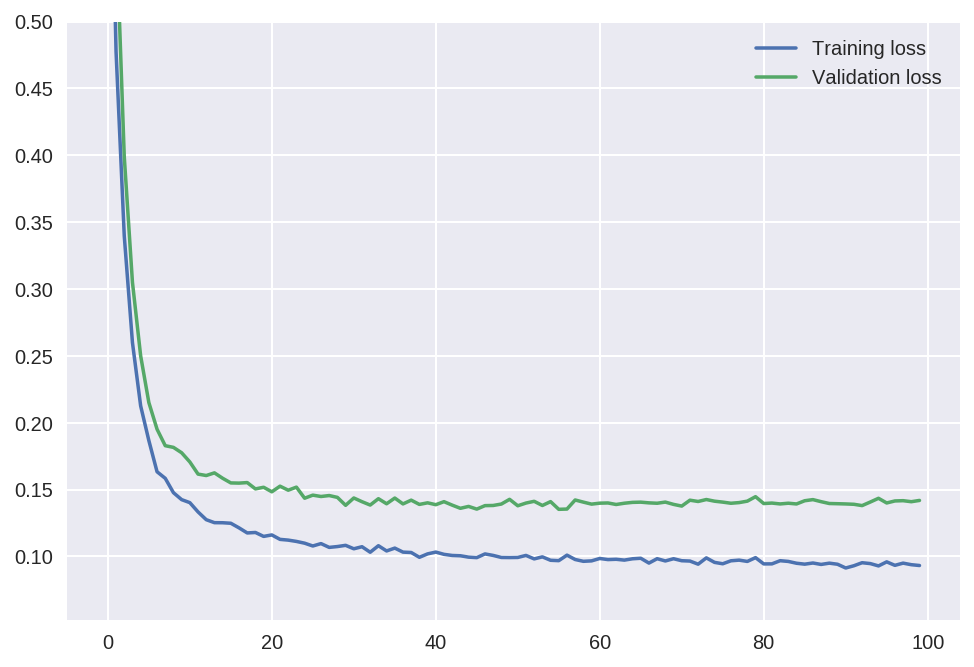

In [10]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU

train_features = np.array(train_features)
train_targets = np.array(train_targets)
val_features = np.array(val_features)
val_targets = np.array(val_targets)
test_features = np.array(test_features)

# Building the model
model = Sequential()
model.add(Dense(28, activation='relu', input_dim = train_features.shape[1]))
model.add(Dropout(.1))
model.add(Dense(14, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(3))

#Activation function: relu and sigmoid
#Loss function: categorical_crossentropy, mean_squared_error
#Optimizer: rmsprop, adam, ada

# Compiling the model

model.compile(loss='mean_squared_error', optimizer='rmsprop')


# model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

print("Training ...")
history = model.fit(train_features, train_targets, epochs=100, batch_size=128, verbose=0,
         validation_data=(val_features, val_targets))

print("Training loss: {:.3f} ... Validation loss: {:.3f}".format(history.history['loss'][-1], 
                                                         history.history['val_loss'][-1]))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.ylim(ymax=0.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

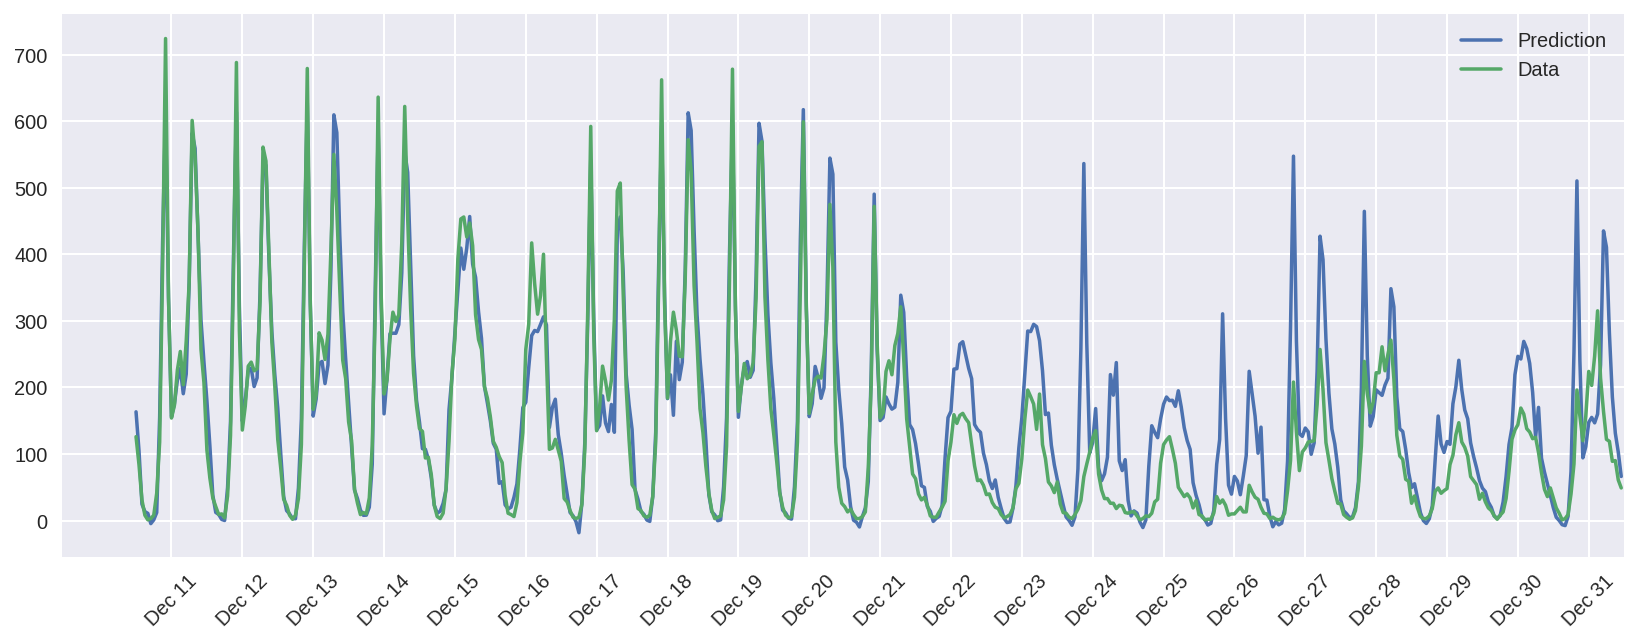

In [11]:
pred = model.predict(test_features)

fig, ax = plt.subplots(figsize=(14,5))

mean, std = scaled_features['cnt']
predictions = pred*std + mean
ax.plot(predictions[:,0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
Answer these questions about your results. How well does the model predict the data? Where does it fail? Why does it fail where it does?

> **Note:** You can edit the text in this cell by double clicking on it. When you want to render the text, press control + enter

#### Your answer below
The model seems quite accurate (training loss < 0.10, validation loss < 0.20, from approx 20 epochs in this Keras version) having into account that only 2 years of data were available. 

It fails on the last 10 days of December, where the bike riders were less than expected (few riders indeed)

The model wasn't trained to predict this drop: the training set included data from December 22 to December 31 just from one year (2011), which is insufficient. A small analysis of the dataset and some tests performed with different models (based on this project on jupyter), led me to the following results and conclusions:

- Adding more features of the dataset to the model has a negligible impact of the accuracy of the model, just makes the network more complex (removing or replacing features makes the model worse).

    
- The period Dec 22 - Dec 31 in 2011, in the training set, had more registered riders (mean = 73.6) than the one in 2012 (mean = 58.3), in the testing set . The rest of features, such those related with the weather, were able to predict a little drop (Christmas weather in 2012 was a bit worse than in 2011), but not the decline registered at Christmas 2012. One or more new features could help to predict these issues, such as including the number of active registrations, or even a boolean 'Christmas' feature.
    
    

    